In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import path
from sklearn.cluster import KMeans

In [107]:
def get_dataset(filename):
    dataset = pd.read_csv(os.path.join("data", filename))
    dataset.drop(index=0, inplace=True)
    for c in dataset.columns:
        if dataset[c].dtype == 'O':
            dataset[c] = dataset[c].str.rstrip('%')
        
    return dataset

In [108]:
off_overview = get_dataset("offensive_overview.csv")
off_overview.columns = ['Player', 'Age', 'Team', 'Pos', 'Min', "Usage_rank", 'Usage', 'PSA_rank', 'PSA', 'AST_pct_rank', 'AST_pct', 'AST_usage_rank', 'AST_usg', 'TOV_pct_rank', 'TOV_pct']
convert_dict = {'AST_pct': float, 'Usage': float, 'PSA': float}
off_overview = off_overview.astype(convert_dict)
off_overview.head(3)

,Player,Age,Team,Pos,Min,Usage_rank,Usage,PSA_rank,PSA,AST_pct_rank,AST_pct,AST_usage_rank,AST_usg,TOV_pct_rank,TOV_pct
1,Steven Adams,26.2,OKC,Big,1448.0,59,17.0,65,120.8,85,13.7,87,0.80,48,13.8
2,Bam Adebayo,22.2,MIA,Big,2035.0,85,21.4,66,121.2,99,22.8,98,1.07,17,16.8
3,LaMarcus Aldridge,34.2,SAS,Big,1706.0,88,22.4,49,116.0,77,11.9,43,0.53,92,8.4


In [114]:
def_reb = get_dataset("defense_and_rebounding.csv")
def_reb.columns = ['Player', 'Age', 'Team', 'Pos', 'Min', 'BLK_pct_rank', 'BLK_pct', 'STL_pct_rank', 'STL_pct', 'FOUL%_rank', 'FOUL_pct', 'fg_OR_pct_rank', 'fg_OR_pct', 'fg_DR_pct_rank', 'fg_DR_pct', 'ftor_pct_rank', 'ftor_pct', 'ft_dr_pct_rank', 'ft_dr_pct']
def_reb.head(5)
convert_dict = {'BLK_pct': float, 'fg_DR_pct': float, 'fg_OR_pct': float, 'STL_pct_rank': float}
def_reb = def_reb.astype(convert_dict)

For this first analysis, I only what bigs and point guards. Having very different player types will allow clusters of players to emerge (I think).

In [115]:
off_bigs_points = off_overview[off_overview.Pos.isin(["Big", "Point"])]
def_reb_bigs_points = def_reb[def_reb.Pos.isin(["Big", "Point"])]
len(off_bigs_points) == len(def_reb_bigs_points)

True

In [117]:
off_and_def = off_bigs_points.merge(def_reb_bigs_points, on='Player')[['Player', 'AST_pct', 'fg_DR_pct', 'Min_x', 'Pos_x']]
off_and_def = off_and_def[off_and_def.Min_x > 480]
off_and_def.head(3)

,Player,AST_pct,fg_DR_pct,Min_x,Pos_x
0,Steven Adams,13.7,21.2,1448.0,Big
1,Bam Adebayo,22.8,21.3,2035.0,Big
2,LaMarcus Aldridge,11.9,16.3,1706.0,Big


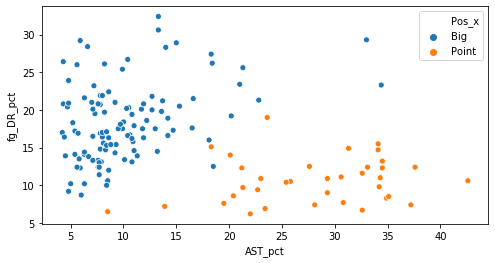

In [118]:
plt.figure(figsize=(8,4))
sns.scatterplot(x='AST_pct', y='fg_DR_pct', data=off_and_def, hue='Pos_x')

In [119]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(off_and_def[['AST_pct', 'fg_DR_pct']])
clusters = kmeans.predict(off_and_def[['AST_pct', 'fg_DR_pct']])

In [120]:
off_and_def['cluster'] = clusters

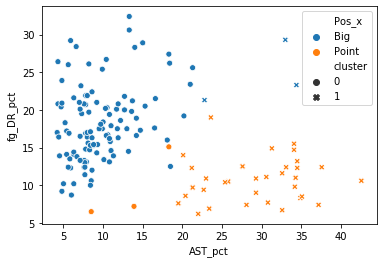

In [121]:
plt.cla()
sns.scatterplot(x='AST_pct', y='fg_DR_pct', data=off_and_def, hue='Pos_x', style='cluster')

In [122]:
off_and_def[(off_and_def.Pos_x=='Big') & (off_and_def.cluster==1)]

,Player,AST_pct,fg_DR_pct,Min_x,Pos_x,cluster
1,Bam Adebayo,22.8,21.3,2035.0,Big,1
4,Giannis Antetokounmpo,33.0,29.3,1621.0,Big,1
106,Nikola Jokic,34.4,23.3,1896.0,Big,1


In [123]:
off_and_def[(off_and_def.Pos_x=='Point') & (off_and_def.cluster==0)]

,Player,AST_pct,fg_DR_pct,Min_x,Pos_x,cluster
15,Patrick Beverley,18.3,15.1,1180.0,Point,0
99,Frank Jackson,8.5,6.5,530.0,Point,0
179,Collin Sexton,13.9,7.2,1890.0,Point,0


Now going to pull in some more datasets to add more features and build clusters

In [136]:
shot_types = get_dataset("shot_types.csv")
shot_types.columns = ['Player', 'Age', 'Team', 'Pos', 'MIN', 'efg_rank', 'efg', 'Rim_rank', 'Rim', 'Short_mid_rank', 'Short_mid', 'Long_mid', 'Long_mid_rank', 'All_mid_rank', 'All_mid', 'Corner_three_rank', 'Corner_three', 'Non_corner_three_rank', 'Non_corner_three', 'All_three_rank', 'All_three']
conversion_dict = {'All_mid': float, 'Rim': float, 'All_three': float}
shot_types = shot_types.astype(conversion_dict)
shot_types.head(3)

,Player,Age,Team,Pos,MIN,efg_rank,efg,Rim_rank,Rim,Short_mid_rank,...,Long_mid,Long_mid_rank,All_mid_rank,All_mid,Corner_three_rank,Corner_three,Non_corner_three_rank,Non_corner_three,All_three_rank,All_three
1,Steven Adams,26.2,OKC,Big,1475.0,71,58.9,72,62.0,99,...,14,1,82,37.0,17,0,0,0,10,0.0
2,Bam Adebayo,22.2,MIA,Big,2072.0,58,56.4,65,59.0,93,...,71,8,90,40.0,29,1,18,0,19,1.0
3,LaMarcus Aldridge,34.2,SAS,Big,1706.0,38,53.7,15,25.0,77,...,100,32,100,57.0,40,3,47,15,44,19.0


In [144]:
foul_drawing = get_dataset("foul_drawing.csv")
foul_drawing.columns = ["Player", "Age", "Team", "Pos", "Min", "FT_rank", "FT_pct", 'SF_rank', 'SF_pct', 'FF_rank', 'FF_pct', 'And1_rank', 'And1_pct']
conversion_dict = {"FT_pct": float, "SF_pct": float}
foul_drawing = foul_drawing.astype(conversion_dict)
foul_drawing.head(3)

,Player,Age,Team,Pos,Min,FT_rank,FT_pct,SF_rank,SF_pct,FF_rank,FF_pct,And1_rank,And1_pct
1,Tobias Harris,27.2,PHI,Forward,2135.0,62,80.0,41,8.3,47,0.9,73,29.1
2,Shai Gilgeous-Alexander,21.3,OKC,Wing,2130.0,55,80.7,85,12.5,95,2.8,63,25.2
3,Devin Booker,23.0,PHX,Wing,2115.0,97,91.6,86,12.7,100,4.0,26,16.9


I am going to build up one dataframe that includes one row per player along with each column I want to use for clustering.

In [169]:
kmeans_data = off_overview[['Player', 'Pos', 'Min', 'Usage', 'AST_pct', 'PSA']]
kmeans_data = kmeans_data.merge(def_reb[['Player','BLK_pct', 'STL_pct', 'fg_OR_pct', 'fg_DR_pct']], on='Player')
foul_drawing.head(3)
kmeans_data = kmeans_data.merge(foul_drawing[['Player', 'FT_pct', 'SF_pct']], on='Player')
kmeans_data = kmeans_data.merge(shot_types[['Player', 'Rim', 'All_mid', 'All_three']], on='Player')